In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
import time as time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataframe=pd.read_csv('/content/drive/MyDrive/colab/ecg.csv',header=None)
raw_data=dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
labels=raw_data[:,-1]
data=raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2,random_state=30)

In [ ]:
min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)
train_data=(train_data-min_val)/(max_val-min_val)
test_data=(test_data-min_val)/(max_val-min_val)
train_data=tf.cast(train_data,tf.float32)
test_data=tf.cast(test_data,tf.float32)
test_data.dtype

tf.float32

In [ ]:
trian_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

normal_train_data = train_data[train_labels==True]
normal_test_data = test_data[test_labels==True]

anomalous_train_data = train_data[train_labels==False]
anomalous_test_data = test_data[test_labels==False]
normal_test_data

<tf.Tensor: shape=(569, 140), dtype=float32, numpy=
array([[0.49796817, 0.376871  , 0.2613258 , ..., 0.5917065 , 0.5552938 ,
        0.4288407 ],
       [0.52103156, 0.4122149 , 0.30279675, ..., 0.582392  , 0.585064  ,
        0.4688135 ],
       [0.53425634, 0.4242953 , 0.30945942, ..., 0.5763559 , 0.604452  ,
        0.5382849 ],
       ...,
       [0.35688347, 0.266708  , 0.25014386, ..., 0.47626334, 0.49910098,
        0.44312167],
       [0.4366895 , 0.3243988 , 0.2507272 , ..., 0.4389508 , 0.42922375,
        0.32930693],
       [0.4370337 , 0.31467113, 0.25910908, ..., 0.45723268, 0.4640259 ,
        0.3439082 ]], dtype=float32)>

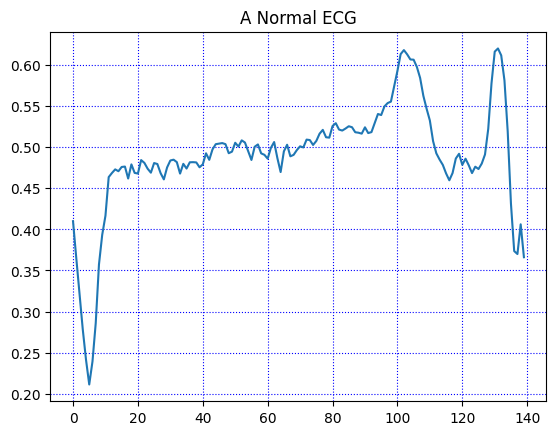

In [ ]:
plt.grid(linestyle=":",color="b")
plt.plot(np.arange(140),normal_train_data[5])
plt.title("A Normal ECG")
plt.show()

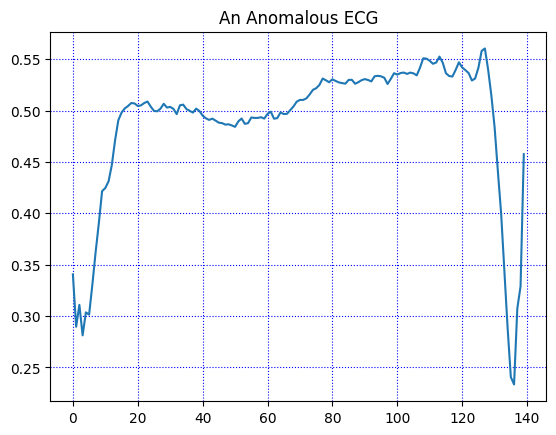

In [ ]:
plt.grid(linestyle=":",color="b")
plt.plot(np.arange(140),anomalous_train_data[5])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
normal_train_data

<tf.Tensor: shape=(2350, 140), dtype=float32, numpy=
array([[0.30190104, 0.22326483, 0.25600037, ..., 0.5872777 , 0.59820604,
        0.53018284],
       [0.46774185, 0.33066246, 0.24793585, ..., 0.5812626 , 0.5517614 ,
        0.44091344],
       [0.43563795, 0.32453567, 0.25424972, ..., 0.430366  , 0.46361226,
        0.38237137],
       ...,
       [0.4766095 , 0.29015893, 0.22824301, ..., 0.5892736 , 0.6296925 ,
        0.5043253 ],
       [0.32076177, 0.15634508, 0.18770842, ..., 0.5052621 , 0.5651693 ,
        0.46607792],
       [0.74391824, 0.53833365, 0.34337005, ..., 0.5607303 , 0.5922149 ,
        0.3577926 ]], dtype=float32)>

In [ ]:
X_normal = normal_train_data
X_abnormal = anomalous_train_data

# Create labels (0 for normal, 1 for abnormal)
y_normal = np.zeros(X_normal.shape[0], dtype=int)
y_abnormal = np.ones(X_abnormal.shape[0], dtype=int)

# Combine normal and abnormal data
X = np.vstack((X_normal, X_abnormal))
y = np.concatenate((y_normal, y_abnormal))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


TOTAL_Len = 200000
X_train = X_train[:TOTAL_Len]

X_test = X_test[:TOTAL_Len]

In [ ]:
import torch.nn as nn
import torch
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x = x + self.pe[:x.size(1), :].squeeze(1)
        x = x + self.pe[:x.size(0), :]
        # return self.dropout(x)
        return x


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout):
        super(TransformerModel, self).__init__()

        # Positional encoding
        self.pos_encoder = PositionalEncoding(input_dim, dropout)

        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        # Output layer
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pooling to aggregate information
        x = self.fc(x)
        return x


In [ ]:
input_dim = X_train.shape[1]  # Input dimension based on the data
hidden_dim = 8
num_heads = 1
num_layers = 6
output_dim = 2  # Binary classification
dropout = 0.5
batch_size = 32
# Create an instance of the model
model = TransformerModel(input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout)

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    predicted_classes = torch.argmax(y_pred, dim=1)
    accuracy = (predicted_classes == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 60.00%
